In [ ]:
import numpy as np
import scipy as sp
import random
%matplotlib inline
import matplotlib.pyplot as plt
#from scipy.signal import ricker
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from keras.layers import GaussianNoise

from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions
tfb = tfp.bijectors

**Dataset Generation**

In [ ]:
def syntheticSeismogram(v, rho, d):
    """
    function syntheticSeismogram()
    syntheicSeismogram generates a synthetic seismogram for a simple 1-D
    layered model.
    The wavelet options are based on (Ryan, 1994):
        Ricker:
        Ormsby:
        Klauder:
        Butterworth:
    Lindsey Heagy
    lheagy@eos.ubc.ca
    November 30, 2013

    v   = np.array([350, 1000, 2000]) # Velocity of each layer (m/s)
    rho = np.array([1700, 2000, 2500]) # Density of each layer (kg/m^3)
    d   = np.array([0, 100, 200]) # Position of top of each layer (m)
    """

    # Ensure that these are float numpy arrays
    v, rho, d = np.array(v, dtype=float), np.array(rho, dtype=float), np.array(d, dtype=float)

    usingT = True

    nlayer = len(v) # number of layers

    # Check that the number of layers match
    assert len(rho) == nlayer, 'Number of layer densities must match number of layer velocities'
    assert len(d)   == nlayer, 'Number of layer tops must match the number of layer velocities'

    # compute necessary parameters
    Z   = rho*v                       # acoustic impedance
    R   = np.diff(Z)/(Z[:-1] + Z[1:]) # reflection coefficients
    twttop  = 2*d[1:]/v[:-1]
    twttop  = np.cumsum(twttop)

    # create model logs
    resolution = 100
    dpth   = np.linspace(0,np.max(d)+np.max(np.diff(d)),resolution)
    nd     = len(dpth)

    rholog  = np.zeros(nd)
    vlog    = np.zeros(nd)
    zlog    = np.zeros(nd)
    rseries = np.zeros(nd)
    twti    = np.zeros(nd)

    for i in range(nlayer):
        di         = (dpth >= d[i])
        rholog[di] = rho[i]
        vlog[di]   = v[i]
        zlog[di]   = Z[i]
        if i < nlayer-1:
            di  = np.logical_and(di, dpth < d[i+1])
            ir = np.arange(resolution)[di][-1:][0] #find(di, 1, 'last' )
            if usingT:
                if i == 0:
                    rseries[ir] = R[i]
                else:
                    rseries[ir] = R[i]*np.prod(1-R[i-1]**2)
            else:
                rseries[ir] = R[i]
        if i > 0:
            twti[di] = twttop[i-1]

    t  = 2.0*dpth/vlog + twti

    # make wavelet
    # Wavelet type and Frequency (Hz):
    wavtyp = 'RICKER'
    wavf   = np.array([10])

    dtwav  = np.abs(np.min(np.diff(t)))
    twav   = np.arange(-2.0/np.min(wavf), 2.0/np.min(wavf), dtwav)

    # Get source wavelet
    wav = {'RICKER':getRicker, 'ORMSBY':getOrmsby, 'KLAUDER':getKlauder}[wavtyp](wavf,twav)

    # create synthetic seismogram
    tseis = np.arange(0,np.max(t),dtwav) + np.min(twav)
    tr    = t[np.abs(rseries) > 0]
    rseriesconv = np.zeros(len(tseis))
    for i in range(len(tr)):
        index = np.abs(tseis - tr[i]).argmin()
        rseriesconv[index] = R[i]

    seis = np.convolve(wav,rseriesconv)
    tseis = np.min(twav)+dtwav*np.arange(len(seis))
    index = np.logical_and(tseis >= 0, tseis <= np.max(t))
    tseis = tseis[index]
    seis  = seis[index]
    ##

    return seis

pi = np.pi
def getRicker(f,t):
    assert len(f) == 1, 'Ricker wavelet needs 1 frequency as input'
    f = f[0]
    pift = pi*f*t
    wav = (1 - 2*pift**2)*np.exp(-pift**2)
    return wav

def getOrmsby(f,t):
    assert len(f) == 4, 'Ormsby wavelet needs 4 frequencies as input'
    f = np.sort(f) #Ormsby wavelet frequencies must be in increasing order
    pif   = pi*f
    den1  = pif[3] - pif[2]
    den2  = pif[1] - pif[0]
    term1 = (pif[3]*np.sinc(pif[3]*t))**2 - (pif[2]*np.sinc(pif[2]))**2
    term2 = (pif[1]*np.sinc(pif[1]*t))**2 - (pif[0]*np.sinc(pif[0]))**2

    wav   = term1/den1 - term2/den2;
    return wav

def getKlauder(f,t,T=5.0):
    assert len(f) == 2, 'Klauder wavelet needs 2 frequencies as input'

    k  = np.diff(f)/T
    f0 = np.sum(f)/2.0
    wav = np.real(np.sin(pi*k*t*(T-t))/(pi*k*t)*np.exp(2*pi*1j*f0*t))
    return wav


In [ ]:
d   = [0, 100, 250, 350] # Position of top of each layer (m)
v   = [1550, 2800, 2000] # Velocity of each layer (m/s)
rho = [1700, 2000, 2500, 1900] # Density of each layer (kg/m^3)



In [ ]:
def generate_velocity(n):
  Vp_dataset = np.ones((n, 4))

  for i in range(n):
    Vp_dataset[i,0] = random.uniform(1500,3000)
    Vp_dataset[i,1] = random.uniform(1500,3000)
    Vp_dataset[i,2] = random.uniform(1500,3000)
    Vp_dataset[i,3] = random.uniform(1500,3000)

  return Vp_dataset

In [ ]:
def generate_traces(n):
  d   = [0, 100, 250, 350] # Position of top of each layer (m)
  rho = [1700, 2000, 2500, 1900] # Density of each layer (kg/m^3)
  Vp = generate_velocity(n)
  seis = []
  for i in range(n):
    trace = syntheticSeismogram(Vp[i,:], rho, d)
    seis.append(trace)

  seis = np.array(seis)
  return seis, Vp

In [ ]:
seis, Vp = generate_traces(500)

<ipython-input-5-546534a5e830>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  seis = np.array(seis)


In [ ]:
def numpy_fillna(data):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out

seis = numpy_fillna(seis)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

# Normalize input variable X
x_scaler = StandardScaler()
X_norm = x_scaler.fit_transform(seis)

# Normalize output variable y
y_scaler = StandardScaler()
y_norm = y_scaler.fit_transform(Vp)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.1, random_state=42) # Use normalized data for training
X_train, X_val, y_train, y_val    = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

MC Dropout

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class MCDropout(tf.keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

# Input layer
inputs = tf.keras.Input(shape=(None, 1))

# Reshape layer
#x = layers.Reshape((None, 1))(inputs)

# Convolutional layers with Dropout
x = layers.Conv1D(filters=30, kernel_size=200, activation='relu', padding = 'same')(inputs)
x = MCDropout(0.5)(x)
x = layers.Conv1D(filters=10, kernel_size=200, activation='relu', padding = 'same')(x)
x = MCDropout(0.5)(x)



# Flatten layer
x = layers.GlobalMaxPooling1D()(x)

# Fully connected layers with Dropout
#x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.3)(x,training = True)


# Output layer with 4 neurons for the 4-layer velocity model_mc
outputs = layers.Dense(4)(x)

# Create the model_mc
model_mc = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model_mc
model_mc.compile(Adam(learning_rate = 0.00005), loss='mse', metrics=['mae'])

# Print the model_mc summary
model_mc.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 30)          6030      
                                                                 
 mc_dropout (MCDropout)      (None, None, 30)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 10)          60010     
                                                                 
 mc_dropout_1 (MCDropout)    (None, None, 10)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                             

In [ ]:
model_mc.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, verbose = 1)

Epoch 1/500
113/113 [==============================] - 66s 575ms/step - loss: 1.1433 - mae: 0.8794 - val_loss: 0.9113 - val_mae: 0.7935
Epoch 2/500
 96/113 [========================>.....] - ETA: 9s - loss: 0.8585 - mae: 0.7700 

KeyboardInterrupt: ignored

In [ ]:
preds = model_mc(X_test, training = False)
y_preds = y_scaler.inverse_transform(preds)
y_test_inv = y_scaler.inverse_transform(y_test)
#y_train_inv = y_scaler.inverse_transform(y_train)
mae = mean_absolute_error(y_preds, y_test_inv)
mae

92.32254466149033

In [ ]:
import numpy as np

# Perform Monte Carlo sampling
n_samples = 300  # Number of Monte Carlo samples
predictions = np.zeros((n_samples, X_test.shape[0], 4))

for i in range(n_samples):
    preds = model_mc(X_test, training = False)
    y_preds = y_scaler.inverse_transform(preds)
    predictions[i] = y_preds

# Calculate mean and standard deviation of predictions
mean_predictions = np.mean(predictions, axis=0)
std_predictions = np.std(predictions, axis=0)


In [ ]:
mae = mean_absolute_error(y_test_inv, mean_predictions)
mae

64.93299861810677

In [ ]:
ll = np.zeros((X_test.shape[0], 4)) # lower limit
ul = np.zeros((X_test.shape[0], 4)) # lower limit

for i in range(X_test.shape[0]):
  ll[i] = mean_predictions[i] - 2*std_predictions[i]
  ul[i] = mean_predictions[i] + 2*std_predictions[i]


In [ ]:
def getlogs(v, d):

    # Ensure that these are float numpy arrays
    v, d = np.array(v, dtype=float), np.array(d, dtype=float)

    nlayer = len(v) # number of layers

    # Check that the number of layers match
    assert len(rho) == nlayer, 'Number of layer densities must match number of layer velocities'
    assert len(d)   == nlayer, 'Number of layer tops must match the number of layer velocities'

    # create model logs
    resolution = 100
    dpth   = np.linspace(0,np.max(d)+np.max(np.diff(d)),resolution)
    nd     = len(dpth)
    vlog    = np.zeros(nd)

    for i in range(nlayer):
        di         = (dpth >= d[i])
        vlog[di]   = v[i]

    return vlog

In [ ]:
resolution = 100
dpth   = np.linspace(0,np.max(d)+np.max(np.diff(d)),resolution)
dpth.shape

(100,)

In [ ]:
Vp_pred = []
Vp_pred_ul = []
Vp_pred_ll = []
Vp_true = []

for j in range(0, X_test.shape[0]):
  Vp_pred.append(getlogs(mean_predictions[j,:],d))
  Vp_true.append(getlogs(y_test_inv[j,:],d))
  Vp_pred_ul.append(getlogs(ul[j,:],d))
  Vp_pred_ll.append(getlogs(ll[j,:],d))


Vp_pred = np.array(Vp_pred)
Vp_true = np.array(Vp_true)
Vp_pred_ul = np.array(Vp_pred_ul)
Vp_pred_ll = np.array(Vp_pred_ll)

In [ ]:
i = random.randint(0, X_test.shape[0])
print(y_test_inv[i])
print(mean_predictions[i])
print(std_predictions[i])
print(mean_absolute_error(y_test_inv[i], mean_predictions[i]))
print(ll[i])
print(ul[i])

[1905.72627819 1532.86334693 2686.32223873 2969.42475704]
[1902.08807698 1524.19218783 2677.36087533 2916.41226034]
[74.329663   69.02014364 72.57008802 71.73280089]
18.570805098302174
[1753.42875098 1386.15190055 2532.2206993  2772.94665856]
[2050.74740298 1662.2324751  2822.50105136 3059.87786212]


In [ ]:
X_true = x_scaler.inverse_transform(X_test)

Text(0.5, 1.0, 'Velocity')

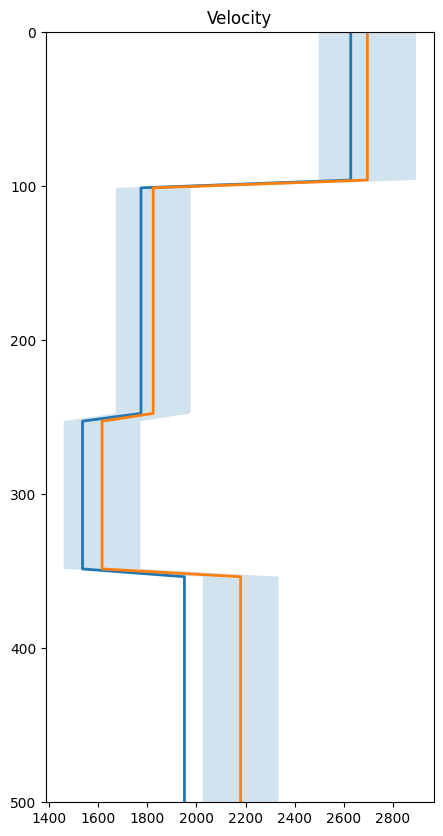

In [ ]:
s = random.randint(0, X_test.shape[0])
plt.subplots(figsize=(5,10))
ax = plt.gca()
ax.set_ylim([max(dpth),min(dpth)])
plt.plot(Vp_true[s,:],dpth,linewidth=2)
plt.plot(Vp_pred[s,:],dpth,linewidth=2)
ax.fill_betweenx(dpth, Vp_pred_ul[s,:], Vp_pred_ll[s,:],  alpha = 0.2)
plt.title('Velocity')

BNN using Variational Inference

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def NLL(y, distr):
  return -distr.log_prob(y)

def normal_sp(params):
  return tfd.Normal(loc=params[:,:4], scale=1e-3 + tf.math.softplus(0.05 * params[:,4:]))# both parameters are learnable


class MCDropout(tf.keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

# Input layer
inputs = tf.keras.Input(shape=(None, 1))

# Reshape layer
#x = layers.Reshape((None, 1))(inputs)

# Convolutional layers with Dropout
x = layers.Conv1D(filters=30, kernel_size=200, activation='relu', padding = 'same')(inputs)
x = MCDropout(0.5)(x)
x = layers.Conv1D(filters=10, kernel_size=200, activation='relu', padding = 'same')(x)
x = MCDropout(0.5)(x)

# Flatten layer
x = layers.Flatten()(x)

# Output layer with 8 neurons for the 4-layer velocity model_mc
params = layers.Dense(8)(x)

outputs = tfp.layers.DistributionLambda(normal_sp, convert_to_tensor_fn = tfd.Distribution.mean)(params)


# Create the model_mc
model_mc = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model_mc
model_mc.compile(Adam(learning_rate = 0.00005), loss=NLL, metrics=['mae'])

# Print the model_mc summary
model_mc.summary()


ValueError: ignored

In [ ]:
model_mc.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32, verbose = 1)

In [ ]:
preds = model_mc(X_test, training = True)
y_preds = y_scaler.inverse_transform(preds.mean())
y_test_inv = y_scaler.inverse_transform(y_test)
#y_train_inv = y_scaler.inverse_transform(y_train)
mae = mean_absolute_error(y_preds, y_test_inv)
mae

156.18357179447054

In [ ]:
# Perform Monte Carlo sampling
n_samples = 300  # Number of Monte Carlo samples
predictions = np.zeros((n_samples, X_test.shape[0], 4))

for i in range(n_samples):
    preds = model_mc(X_test, training = False)
    y_preds = y_scaler.inverse_transform(preds.mean())
    predictions[i] = y_preds

# Calculate mean and standard deviation of predictions
mean_predictions = np.mean(predictions, axis=0)
std_predictions = np.std(predictions, axis=0)

In [ ]:
mae = mean_absolute_error(y_test_inv, mean_predictions)
mae

151.66995303460115

In [ ]:
std_predictions

In [ ]:
X_true = x_scaler.inverse_transform(X_test)

In [ ]:
y_ul = preds.mean() + 2*preds.stddev()
y_ll = preds.mean() - 2*preds.stddev()

In [ ]:
y_ul = y_scaler.inverse_transform(y_ul)
y_ll = y_scaler.inverse_transform(y_ll)

In [ ]:
Vp_pred = np.ones((X_test.shape[0], l))
y_actual = np.ones((X_test.shape[0], l))
Vp_pred_ul = np.ones((X_test.shape[0], l))
Vp_pred_ll = np.ones((X_test.shape[0], l))


for i in range(X_test.shape[0]):
  Vp_pred[i,0:int(l/4)] = y_preds[i][0]
  Vp_pred[i,int(l/4):int(l/2)] = y_preds[i][1]
  Vp_pred[i,int(l/2):int(3*l/4)] = y_preds[i][2]
  Vp_pred[i,int(3*l/4):l] = y_preds[i][3]

  y_actual[i,0:int(l/4)] = y_test_inv[i][0]
  y_actual[i,int(l/4):int(l/2)] = y_test_inv[i][1]
  y_actual[i,int(l/2):int(3*l/4)] = y_test_inv[i][2]
  y_actual[i,int(3*l/4):l] = y_test_inv[i][3]

  Vp_pred_ul[i,0:int(l/4)] = y_ul[i][0]
  Vp_pred_ul[i,int(l/4):int(l/2)] = y_ul[i][1]
  Vp_pred_ul[i,int(l/2):int(3*l/4)] = y_ul[i][2]
  Vp_pred_ul[i,int(3*l/4):l] = y_ul[i][3]

  Vp_pred_ll[i,0:int(l/4)] = y_ll[i][0]
  Vp_pred_ll[i,int(l/4):int(l/2)] = y_ll[i][1]
  Vp_pred_ll[i,int(l/2):int(3*l/4)] = y_ll[i][2]
  Vp_pred_ll[i,int(3*l/4):l] = y_ll[i][3]

Text(0.5, 0, 'Velocity Model')

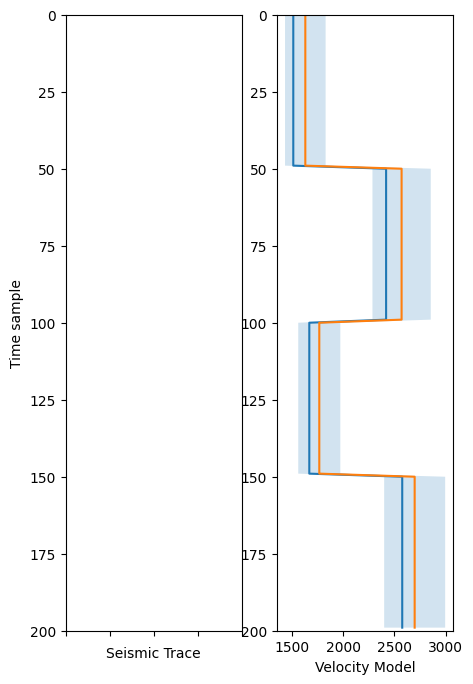

In [ ]:
s = random.randint(0, X_test.shape[0])
fig, axs = plt.subplots(ncols=2, figsize=(5, 8))

ax = axs[0]
ax.set_xlabel('Seismic Trace')
ax.set_ylabel('Time sample')
ax.set_ylim(l, 0)
ax.set_xticklabels([])
ax.plot(X_true[s,:], Ts[0:l])

ax = axs[1]
ax.set_ylim(l, 0)
ax.plot(y_actual[s,:], Ts[0:l])
ax.plot(Vp_pred[s,:], Ts[0:l])
#ax.plot(Vp_pred_ul[s,:], Ts[0:l])
#ax.plot(Vp_pred_ll[s,:], Ts[0:l])
ax.fill_betweenx(Ts[0:l], Vp_pred_ul[s,:], Vp_pred_ll[s,:],  alpha = 0.2)
ax.set_xlabel('Velocity Model')

Bayesian CNN

In [ ]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_norm.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_norm.shape[0] * 1.0)

def NLL(y, distr):
  return -distr.log_prob(y)

class MCDropout(tf.keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

def normal_sp(params):
  return tfd.Normal(loc=params[:,:4], scale=1e-3 + tf.math.softplus(0.05 * params[:,4:]))# both parameters are learnable

inputs = Input(shape=(l,1))


hidden = tfp.layers.Convolution1DFlipout(filters=32, kernel_size=40, activation='relu',bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(inputs)
hidden = tfp.layers.Convolution1DFlipout(filters=16, kernel_size=30, activation='relu',bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)

hidden = layers.Flatten()(hidden)

params = tfp.layers.DenseFlipout(8,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)

outputs = tfp.layers.DistributionLambda(normal_sp, convert_to_tensor_fn = tfd.Distribution.mean)(params)


model_vi = Model(inputs=inputs, outputs=outputs)
model_vi.compile(Adam(learning_rate = 0.0005), loss=NLL, metrics=['mae'])



In [ ]:
model_vi.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose = 1)

Epoch 1/30
113/113 [==============================] - 1s 10ms/step - loss: 1.4089 - mae: 0.3958 - val_loss: 1.3737 - val_mae: 0.3803
Epoch 2/30
113/113 [==============================] - 1s 9ms/step - loss: 1.4012 - mae: 0.3968 - val_loss: 1.3544 - val_mae: 0.3793
Epoch 3/30
113/113 [==============================] - 1s 10ms/step - loss: 1.3945 - mae: 0.3974 - val_loss: 1.3430 - val_mae: 0.3736
Epoch 4/30
113/113 [==============================] - 1s 12ms/step - loss: 1.4117 - mae: 0.3994 - val_loss: 1.3956 - val_mae: 0.3800
Epoch 5/30
113/113 [==============================] - 2s 15ms/step - loss: 1.3810 - mae: 0.3949 - val_loss: 1.3536 - val_mae: 0.3778
Epoch 6/30
113/113 [==============================] - 1s 10ms/step - loss: 1.3890 - mae: 0.3969 - val_loss: 1.3634 - val_mae: 0.3762
Epoch 7/30
113/113 [==============================] - 1s 9ms/step - loss: 1.3887 - mae: 0.3976 - val_loss: 1.3621 - val_mae: 0.3827
Epoch 8/30
113/113 [==============================] - 1s 9ms/step - los

In [ ]:
preds = model_vi(X_test)
y_preds = y_scaler.inverse_transform(preds.mean())
y_test_inv = y_scaler.inverse_transform(y_test)
#y_train_inv = y_scaler.inverse_transform(y_train)
mae = mean_absolute_error(y_preds, y_test_inv)
mae

168.35361748504505

In [ ]:
y_ul = preds.mean() + 2*preds.stddev()
y_ll = preds.mean() - 2*preds.stddev()

In [ ]:
y_ul = y_scaler.inverse_transform(y_ul)
y_ll = y_scaler.inverse_transform(y_ll)

In [ ]:
Vp_pred = np.ones((X_test.shape[0], l))
y_actual = np.ones((X_test.shape[0], l))
Vp_pred_ul = np.ones((X_test.shape[0], l))
Vp_pred_ll = np.ones((X_test.shape[0], l))


for i in range(X_test.shape[0]):
  Vp_pred[i,0:int(l/4)] = y_preds[i][0]
  Vp_pred[i,int(l/4):int(l/2)] = y_preds[i][1]
  Vp_pred[i,int(l/2):int(3*l/4)] = y_preds[i][2]
  Vp_pred[i,int(3*l/4):l] = y_preds[i][3]

  y_actual[i,0:int(l/4)] = y_test_inv[i][0]
  y_actual[i,int(l/4):int(l/2)] = y_test_inv[i][1]
  y_actual[i,int(l/2):int(3*l/4)] = y_test_inv[i][2]
  y_actual[i,int(3*l/4):l] = y_test_inv[i][3]

  Vp_pred_ul[i,0:int(l/4)] = y_ul[i][0]
  Vp_pred_ul[i,int(l/4):int(l/2)] = y_ul[i][1]
  Vp_pred_ul[i,int(l/2):int(3*l/4)] = y_ul[i][2]
  Vp_pred_ul[i,int(3*l/4):l] = y_ul[i][3]

  Vp_pred_ll[i,0:int(l/4)] = y_ll[i][0]
  Vp_pred_ll[i,int(l/4):int(l/2)] = y_ll[i][1]
  Vp_pred_ll[i,int(l/2):int(3*l/4)] = y_ll[i][2]
  Vp_pred_ll[i,int(3*l/4):l] = y_ll[i][3]

Text(0.5, 0, 'Velocity Model')

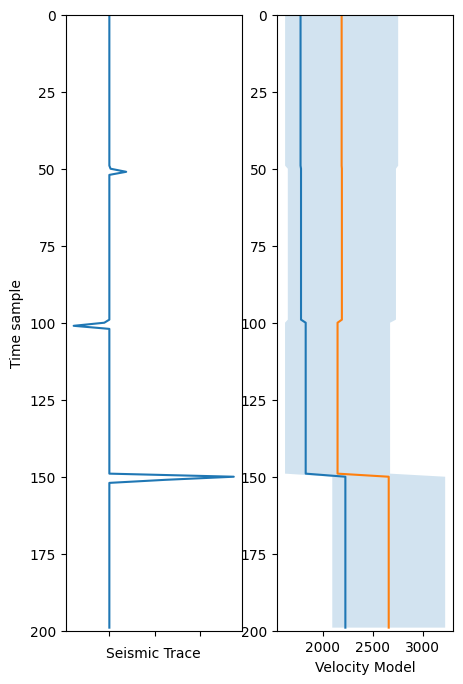

In [ ]:
s = random.randint(0, X_test.shape[0])
fig, axs = plt.subplots(ncols=2, figsize=(5, 8))

ax = axs[0]
ax.set_xlabel('Seismic Trace')
ax.set_ylabel('Time sample')
ax.set_ylim(l, 0)
ax.set_xticklabels([])
ax.plot(X_true[s,:], Ts[0:l])

ax = axs[1]
ax.set_ylim(l, 0)
ax.plot(y_actual[s,:], Ts[0:l])
ax.plot(Vp_pred[s,:], Ts[0:l])
#ax.plot(Vp_pred_ul[s,:], Ts[0:l])
#ax.plot(Vp_pred_ll[s,:], Ts[0:l])
ax.fill_betweenx(Ts[0:l], Vp_pred_ul[s,:], Vp_pred_ll[s,:],  alpha = 0.2)
ax.set_xlabel('Velocity Model')

Gaussian Process Regression

In [ ]:
kernel = 1 * RBF(length_scale=0.1, length_scale_bounds=(10, 10))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha = 0.04)
gaussian_process.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.04, kernel=1**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=100)

In [ ]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

In [ ]:
y_preds = y_scaler.inverse_transform(mean_prediction)
y_test_inv = y_scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_preds, y_test_inv)
#mae = mean_absolute_error(mean_prediction, y_test)
mae

137.66301208042756

In [ ]:
ll = np.zeros((X_test.shape[0], 4)) # lower limit
ul = np.zeros((X_test.shape[0], 4)) # lower limit

for i in range(X_test.shape[0]):
  ll[i] = mean_prediction[i] - 2*std_prediction[i]
  ul[i] = mean_prediction[i] + 2*std_prediction[i]

ll = y_scaler.inverse_transform(ll)
ul = y_scaler.inverse_transform(ul)

In [ ]:
def getlogs(v, d):

    # Ensure that these are float numpy arrays
    v, d = np.array(v, dtype=float), np.array(d, dtype=float)

    nlayer = len(v) # number of layers

    # Check that the number of layers match
    assert len(rho) == nlayer, 'Number of layer densities must match number of layer velocities'
    assert len(d)   == nlayer, 'Number of layer tops must match the number of layer velocities'

    # create model logs
    resolution = 100
    dpth   = np.linspace(0,np.max(d)+np.max(np.diff(d)),resolution)
    nd     = len(dpth)
    vlog    = np.zeros(nd)

    for i in range(nlayer):
        di         = (dpth >= d[i])
        vlog[di]   = v[i]

    return vlog

In [ ]:
resolution = 100
dpth   = np.linspace(0,np.max(d)+np.max(np.diff(d)),resolution)


In [ ]:
Vp_pred = []
Vp_pred_ul = []
Vp_pred_ll = []
Vp_true = []

for j in range(0, X_test.shape[0]):
  Vp_pred.append(getlogs(y_preds[j,:],d))
  Vp_true.append(getlogs(y_test_inv[j,:],d))
  Vp_pred_ul.append(getlogs(ul[j,:],d))
  Vp_pred_ll.append(getlogs(ll[j,:],d))


Vp_pred = np.array(Vp_pred)
Vp_true = np.array(Vp_true)
Vp_pred_ul = np.array(Vp_pred_ul)
Vp_pred_ll = np.array(Vp_pred_ll)

In [ ]:
i = random.randint(0, X_test.shape[0])
print(y_test_inv[i])
print(y_preds[i])
print(mean_absolute_error(y_test_inv[i], y_preds[i]))
print(ll[i])
print(ul[i])

[2029.01616162 2206.33302974 2398.85106993 2288.67061804]
[2202.24078905 2305.40185337 2427.17621155 2421.59885154]
108.38670654394957
[1824.95973917 1931.12182737 2031.07896343 2042.22606794]
[2579.52183894 2679.68187937 2823.27345966 2800.97163514]


Text(0.5, 1.0, 'Velocity')

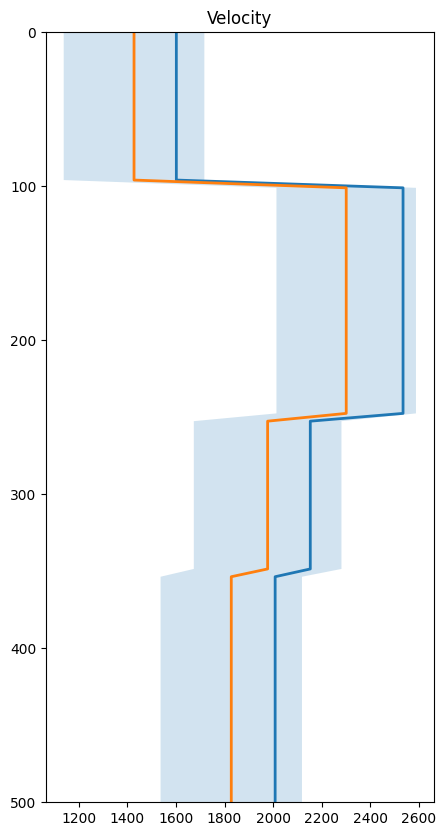

In [ ]:
s = random.randint(0, X_test.shape[0])
plt.subplots(figsize=(5,10))
ax = plt.gca()
ax.set_ylim([max(dpth),min(dpth)])
plt.plot(Vp_true[s,:],dpth,linewidth=2)
plt.plot(Vp_pred[s,:],dpth,linewidth=2)
ax.fill_betweenx(dpth, Vp_pred_ul[s,:], Vp_pred_ll[s,:],  alpha = 0.2)
plt.title('Velocity')